# Connect to drive

In [ ]:
# Connecting to drive
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks/Statistical Learning for Healthcare Data/Project/Scripts/Final code

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/Statistical Learning for Healthcare Data/Project/Scripts/Final code


# Import modules

In [ ]:
# To set the seed for reproducibility
import random

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz # to visualize RFs
import graphviz # to visualize RFs

# Model selection and CV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.inspection import permutation_importance

# To create a RF classifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Set seed
random.seed(562023)

# RF classification and feature importance

### Data preparation and model training

We need to separate the variables which are going to be the input in our classifier and the target variable.

In [ ]:
# Loading the training set
train_set = pd.read_csv('train_set.csv', sep=',')
print("Train set:\n", train_set.head())
print("Train set dimensions: ", train_set.shape)
print("Missing values in the train set: ", train_set.isna().sum().sum())

# Loading the test set
test_set = pd.read_csv('test_set.csv', sep=',')
print("Test set:\n", test_set.head())
print("Test set dimensions: ", test_set.shape)
print("Missing values in the test set: ", test_set.isna().sum().sum())

Train set:
    Unnamed: 0       AGE  SEX  INF_ANAM  STENOK_AN  FK_STENOK  IBS_POST  \
0           0  0.338462  1.0  1.000000   0.666667   0.750000   0.50000   
1           1  0.516902  1.0  0.000000   0.000000   0.000000   0.00000   
2           2  0.492308  0.0  0.000000   0.833333   0.500000   1.00000   
3           3  0.507966  1.0  0.260452   0.325565   0.195339   1.00000   
4           4  0.675928  0.0  0.000000   0.863910   0.500000   0.90827   

         GB  SIM_GIPERT   DLIT_AG  ...  B_BLOK_S_n  ANT_CA_S_n  GEPAR_S_n  \
0  0.000000    0.000000  0.000000  ...         0.0    1.000000   1.000000   
1  0.000000    0.000000  0.000000  ...         0.0    0.359864   1.000000   
2  0.666667    0.000000  0.142857  ...         0.0    1.000000   1.000000   
3  0.000000    0.000000  0.000000  ...         0.0    0.000000   0.609321   
4  0.122306    0.816541  1.000000  ...         0.0    0.816541   1.000000   

   ASP_S_n  TIKL_S_n  TRENT_S_n      R_AB  NA_R  NOT_NA  Target  
0      1.0    

For the same analysis, but using the MICE dataset.

In [ ]:
# Loading the training set
train_set = pd.read_csv('train_set_mice.csv', sep=',')
print("Train set:\n", train_set.head())
print("Train set dimensions: ", train_set.shape)
print("Missing values in the train set: ", train_set.isna().sum().sum())

# Loading the test set
test_set = pd.read_csv('test_set_mice.csv', sep=',')
print("Test set:\n", test_set.head())
print("Test set dimensions: ", test_set.shape)
print("Missing values in the test set: ", test_set.isna().sum().sum())

Train set:
    Unnamed: 0       AGE  SEX  INF_ANAM  STENOK_AN  FK_STENOK  IBS_POST  \
0           0  0.430769  1.0  0.333333   0.500000        0.5       0.5   
1           1  0.723077  1.0  0.000000   0.000000        0.0       1.0   
2           2  0.369231  1.0  0.000000   0.000000        0.0       1.0   
3           3  0.584615  1.0  0.000000   0.166667        0.5       0.5   
4           4  0.553846  1.0  0.000000   1.000000        0.5       1.0   

         GB  SIM_GIPERT   DLIT_AG  ...  B_BLOK_S_n  ANT_CA_S_n  GEPAR_S_n  \
0  1.000000         0.0  0.000000  ...         0.0         0.0        0.0   
1  0.666667         0.0  0.285714  ...         0.0         1.0        0.0   
2  0.666667         0.0  0.857143  ...         0.0         0.0        1.0   
3  0.000000         0.0  0.000000  ...         0.0         1.0        1.0   
4  0.000000         0.0  0.000000  ...         0.0         0.0        1.0   

   ASP_S_n  TIKL_S_n  TRENT_S_n  R_AB  NA_R  NOT_NA  Target  
0      0.0       0

In [ ]:
# Split the data into features (X) and target (y)
y_train = train_set.Target
X_train = train_set.drop(['Unnamed: 0', 'R_AB', 'NA_R', 'NOT_NA','Target'], axis=1)
print(X_train.head())
print(X_train.shape)
print(X_train.isna().sum().sum())

y_test = test_set.Target
X_test = test_set.drop(['Unnamed: 0', 'R_AB', 'NA_R', 'NOT_NA','Target'], axis=1)
print(X_test.head())
print(X_test.shape)
print(X_test.isna().sum().sum())

        AGE  SEX  INF_ANAM  STENOK_AN  FK_STENOK  IBS_POST        GB  \
0  0.430769  1.0  0.333333   0.500000        0.5       0.5  1.000000   
1  0.723077  1.0  0.000000   0.000000        0.0       1.0  0.666667   
2  0.369231  1.0  0.000000   0.000000        0.0       1.0  0.666667   
3  0.584615  1.0  0.000000   0.166667        0.5       0.5  0.000000   
4  0.553846  1.0  0.000000   1.000000        0.5       1.0  0.000000   

   SIM_GIPERT   DLIT_AG  ZSN_A  ...       ROE  TIME_B_S  NITR_S  LID_S_n  \
0         0.0  0.000000    0.0  ...  0.089552     0.750     0.0      1.0   
1         0.0  0.285714    0.0  ...  0.149254     0.125     0.0      0.0   
2         0.0  0.857143    0.0  ...  0.149254     0.125     0.0      0.0   
3         0.0  0.000000    0.0  ...  0.104478     0.750     0.0      0.0   
4         0.0  0.000000    0.0  ...  0.029851     0.625     0.0      0.0   

   B_BLOK_S_n  ANT_CA_S_n  GEPAR_S_n  ASP_S_n  TIKL_S_n  TRENT_S_n  
0         0.0         0.0        0.0     

A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting

In [ ]:
# Fitting the model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

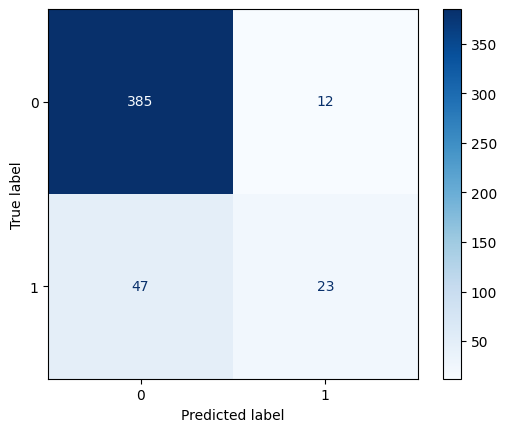

In [ ]:
# Confusion matrix
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues');

In [ ]:
# Model accuracy, sensitivity, specificity, precision and perfonce measure
tot = sum(sum(cm))
accuracy = (cm[0,0] + cm[1,1]) / tot
print("Accuracy:", accuracy)

sensitivity = cm[1,1] / (cm[1,1] + cm[1,0])
print("Model sensitivity: ", sensitivity)

specificity = cm[0,0] / (cm[0,0] + cm[0,1])
print("Model specificity: ", specificity)

precision = cm[1,1] / (cm[1,1] + cm[0,1])
print("Model precision: ", precision)

GabriMeasure = 0.2*accuracy + 0.4*sensitivity + 0.2*precision + 0.2*specificity
print("Model performance with our personal measure: ", GabriMeasure)

Accuracy: 0.8736616702355461
Model sensitivity:  0.32857142857142857
Model specificity:  0.9697732997481109
Model precision:  0.6571428571428571
Model performance with our personal measure:  0.6315441368538743


We need to improve the sensitivity of the model.

### Hyperparameters tuning

Using Scikit-Learn’s RandomizedSearchCV method, we can define a grid of hyperparameter ranges, and randomly sample from the grid, performing K-Fold CV with each combination of values.

Most important hyperparameters of Random Forest:
* n_estimators = n of trees
* max_features = max number of features considered for splitting a node
* max_depth = max number of levels in each decision tree
* min_samples_split = min number of data points placed in a node before the node is split
* min_samples_leaf = min number of data points allowed in a leaf node
* bootstrap = method for sampling data points (with or without replacement)


In [ ]:
# Setting the hyperparameters
random_grid = {'n_estimators':[100,200,300,400,500],
               'criterion':['gini', 'entropy'],
               'max_depth':[5,10,20,30,40,50,60,70],
               'min_samples_split':[5,10,20,25,30,40,50],
               'max_features':[ 'sqrt', 'log2'],
               'max_leaf_nodes':[5,10,20,25,30,40,50],
               'min_samples_leaf':[1,100,200,300,400,500]
               }


# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state=42)

# Random search of parameters, using 10 fold cross validation
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                               n_iter = 30, cv = 10, verbose=2, random_state=42,
                               n_jobs = -1, scoring='neg_mean_squared_error')

# Fit the random search model
rf_random.fit(X_train, y_train);

# Create a variable for the best model
best_rf = rf_random.best_estimator_

Fitting 10 folds for each of 30 candidates, totalling 300 fits


In [ ]:
# Print the best hyperparameters
print('Best hyperparameters:',  rf_random.best_params_)

Best hyperparameters: {'n_estimators': 500, 'min_samples_split': 25, 'min_samples_leaf': 1, 'max_leaf_nodes': 40, 'max_features': 'log2', 'max_depth': 40, 'criterion': 'entropy'}


To improve the sensitivity of the model, we chage the thresholds which is set (by default) to 0.5. To do that, we evaluate the performance of a Rf giving different thresholds and performing for each one of them a 5-folds CV.

In [ ]:
# K-fold CV
K = 5
# Thresholds to determine if a predicted value falls in class 0 or 1
threshold = np.arange(0.1, 0.9, 0.05)
# Extremes of the dataset for the CV
ext = np.linspace(0, X_train.shape[0], K+1).astype(int)

# Metrics
acc = np.zeros(shape=K)
sens = np.zeros(shape=K)
spec = np.zeros(shape=K)
prec = np.zeros(shape=K)
accuracy = np.zeros(shape=len(threshold))
sensitivity = np.zeros(shape=len(threshold))
specificity = np.zeros(shape=len(threshold))
precision = np.zeros(shape=len(threshold))
gabri_measure = np.zeros(shape=len(threshold))

# Model
mod = RandomForestClassifier(n_estimators=500, min_samples_split=25, min_samples_leaf=1,
                             max_leaf_nodes=40, max_features='log2', max_depth=40,
                             criterion='entropy', random_state=42)

In [ ]:
# K-fold CV
for i in range(0, len(threshold)):
  for k in range(0, K):
    # Training and validation tests
    train = X_train.drop(X_train.iloc[ext[k]:ext[k+1]].index)
    y_t = y_train.drop(X_train.iloc[ext[k]:ext[k+1]].index)
    validation = X_train.iloc[ext[k]:ext[k+1]]
    y_val = y_train[ext[k]:ext[k+1]]

    # Training the model
    mod.fit(train,y_t)

    # Predicting values
    predicted_values = mod.predict_proba(validation)[:, 1]
    predicted_class = np.zeros(predicted_values.shape)
    predicted_class[predicted_values > threshold[i]] = 1

    # Accuracy, sensitivity and specificity for every validation set
    cm = confusion_matrix(y_val, predicted_class)
    total = sum(sum(cm))
    acc[k] = (cm[0,0] + cm[1,1]) / total
    sens[k] = cm[1,1] / (cm[1,1] + cm[1,0])
    spec[k] = cm[0,0] / (cm[0,0] + cm[0,1])
    prec[k] = cm[1,1] / (cm[1,1] + cm[0,1])

  # Accuracy, sensitivity and specificity for the chosen threshold
  accuracy[i] = acc.mean()
  sensitivity[i] = sens.mean()
  specificity[i] = spec.mean()
  precision[i] = prec.mean()
  gabri_measure[i] = 0*accuracy[i] + 0.5*sensitivity[i] + 0.3*precision[i] + 0.2*specificity[i]

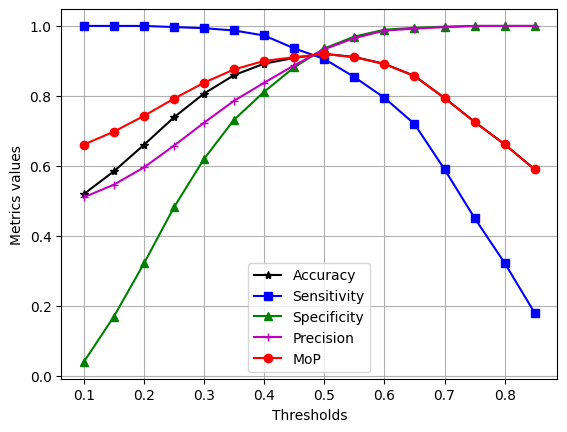

In [ ]:
# Plots
plt.plot(threshold, accuracy, 'k*-', label='Accuracy')
plt.plot(threshold, sensitivity, 'bs-', label='Sensitivity')
plt.plot(threshold, specificity, 'g^-', label='Specificity')
plt.plot(threshold, precision, 'm+-', label='Precision')
plt.plot(threshold, gabri_measure, 'ro-', label='MoP')
plt.xlabel('Thresholds')
plt.ylabel('Metrics values')
plt.grid(True)
plt.legend()
plt.show()

### Model testing

We test the best model.

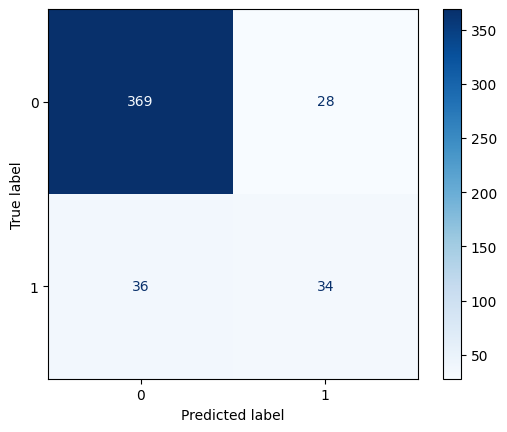

In [ ]:
# Confusion matrix
y_pred = best_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues');

In [ ]:
# Model accuracy, sensitivity, specificity, precision and perfonce measure
tot = sum(sum(cm))
accuracy = (cm[0,0] + cm[1,1]) / tot
print("Accuracy:", accuracy)

sensitivity = cm[1,1] / (cm[1,1] + cm[1,0])
print("Model sensitivity: ", sensitivity)

specificity = cm[0,0] / (cm[0,0] + cm[0,1])
print("Model specificity: ", specificity)

precision = cm[1,1] / (cm[1,1] + cm[0,1])
print("Model precision: ", precision)

GabriMeasure = 0.5*sensitivity + 0.3*precision + 0.2*specificity
print("Model performance with our personal measure: ", GabriMeasure)

Accuracy: 0.8629550321199143
Model sensitivity:  0.4857142857142857
Model specificity:  0.929471032745592
Model precision:  0.5483870967741935
Model performance with our personal measure:  0.5932674784385192


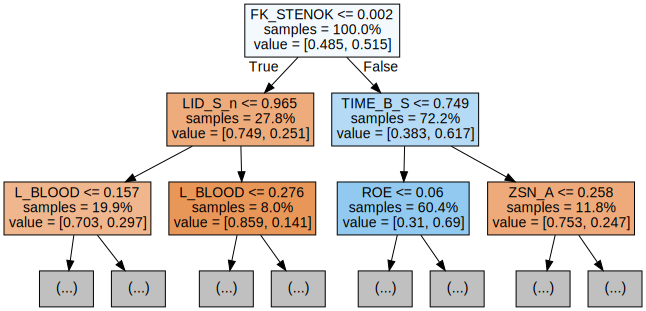

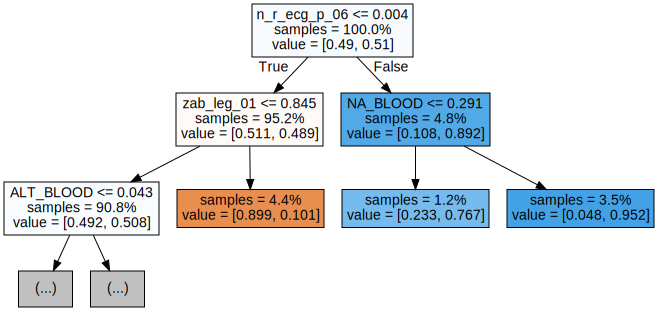

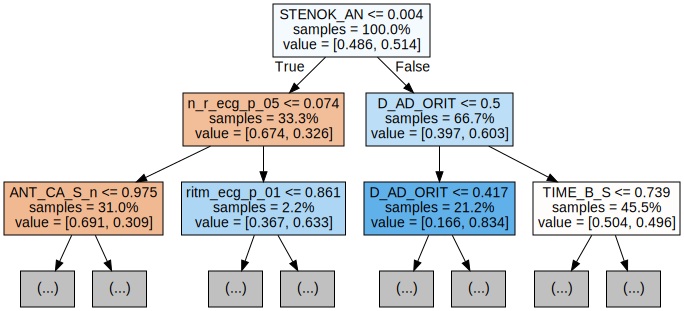

In [ ]:
# Export the first three decision trees from the forest
for i in range(3):
    tree = best_rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_test.columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

Now, we change the threshold to the best model.

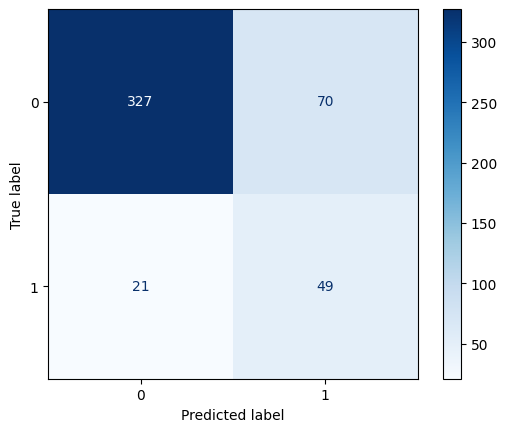

In [ ]:
# Confusion matrix
y_pred = (best_rf.predict_proba(X_test)[:,1] > 0.4).astype(int)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues');

In [ ]:
# Model accuracy, sensitivity, specificity, precision and perfonce measure
tot = sum(sum(cm))
accuracy = (cm[0,0] + cm[1,1]) / tot
print("Accuracy:", accuracy)

sensitivity = cm[1,1] / (cm[1,1] + cm[1,0])
print("Model sensitivity: ", sensitivity)

specificity = cm[0,0] / (cm[0,0] + cm[0,1])
print("Model specificity: ", specificity)

precision = cm[1,1] / (cm[1,1] + cm[0,1])
print("Model precision: ", precision)

GabriMeasure = 0*accuracy + 0.5*sensitivity + 0.3*precision + 0.2*specificity
print("Model performance with our personal measure: ", GabriMeasure)

Accuracy: 0.8051391862955032
Model sensitivity:  0.7
Model specificity:  0.8236775818639799
Model precision:  0.4117647058823529
Model performance with our personal measure:  0.6382649281375019


### Features selection

The feature importance describes which features are relevant.

The Random Forest algorithm has built-in feature importance which can be computed in two ways:
1. **Gini importance** (or **mean decrease impurity**), which is computed from the Random Forest structure. A Random Forest is a set of Decision Trees. Each Decision Tree is a set of internal nodes and leaves. In the internal node, the selected feature is used to make decision on how to divide the data set into two separate sets with similars responses within. The features for internal nodes are selected with some criterion, which for classification tasks can be gini impurity or infomation gain, and for regression is variance reduction. We can measure how each feature decrease the impurity of the split (the feature with highest decrease is selected for internal node). For each feature we can collect how on average it decreases the impurity. The average over all trees in the forest is the measure of the feature importance. In this method we should look at relative values of the computed importances. Advantage of this method is all needed values are computed during the Radom Forest training. The drawbacks is the tendency to prefer numerical features and categorical features with high cardinality. What is more, in the case of correlated features it can select one of the feature and neglect the importance of the second one (which can lead to wrong conclusions).
2. **Mean Decrease Accuracy**  is a method of computing the feature importance on permuted out-of-bag (OOB) samples based on mean decrease in the accuracy. This method is not implemented in the scikit-learn package. The very similar to this method is permutation based importance described below in this post.


Selected features:  Index(['ZSN_A', 'DLIT_AG', 'np_05', 'np_07', 'nr_03', 'np_01', 'np_09',
       'np_08', 'np_04', 'nr_11', 'nr_04', 'zab_leg_01', 'SIM_GIPERT',
       'zab_leg_02', 'STENOK_AN', 'nr_08', 'endocr_01', 'FK_STENOK', 'GB',
       'INF_ANAM', 'nr_07', 'IBS_POST', 'SEX', 'endocr_03', 'nr_01', 'nr_02',
       'endocr_02', 'AGE', 'np_10'],
      dtype='object') (n. selected features:  29 )


Text(0.5, 0, 'Random Forest Feature Importance')

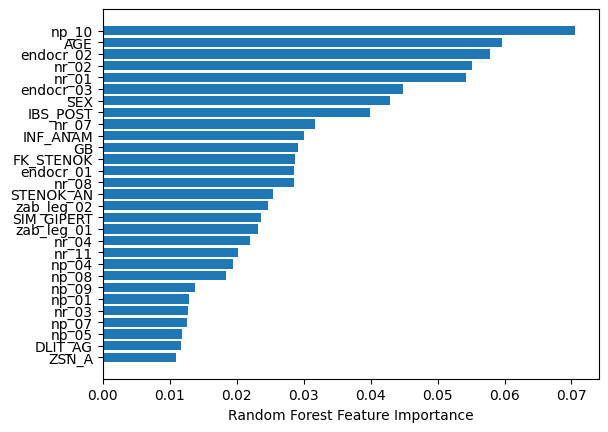

In [ ]:
# Plot of features importances grater than the mean importance
fi = best_rf.feature_importances_[best_rf.feature_importances_ > best_rf.feature_importances_.mean()]
sorted_idx = fi.argsort()
print("Selected features: ", X_train.columns[sorted_idx], "(n. selected features: ",
      len(X_train.columns[sorted_idx]), ")")

plt.barh(X_train.columns[sorted_idx], fi[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

Selected features:  Index(['n_r_ecg_p_06', 'ritm_ecg_p_02', 'FIB_G_POST', 'K_SH_POST',
       'n_p_ecg_p_06', 'ritm_ecg_p_08', 'n_p_ecg_p_10', 'n_r_ecg_p_05',
       'TRENT_S_n', 'nr_04', 'n_p_ecg_p_03', 'B_BLOK_S_n', 'n_p_ecg_p_11',
       'n_r_ecg_p_08', 'SVT_POST', 'SIM_GIPERT', 'O_L_POST', 'ZSN_A',
       'endocr_02', 'nr_02', 'n_p_ecg_p_07', 'n_r_ecg_p_03', 'nr_11',
       'n_p_ecg_p_08', 'zab_leg_03', 'zab_leg_01', 'endocr_01', 'MP_TP_POST',
       'n_r_ecg_p_01', 'GEPAR_S_n', 'LID_S_n', 'post_im', 'K_BLOOD',
       'ritm_ecg_p_07', 'AST_BLOOD', 'inf_im', 'GB', 'FK_STENOK', 'INF_ANAM',
       'NA_BLOOD', 'DLIT_AG', 'ASP_S_n', 'zab_leg_02', 'STENOK_AN', 'IM_PG_P',
       'ALT_BLOOD', 'n_p_ecg_p_12', 'ANT_CA_S_n', 'ritm_ecg_p_01', 'SEX',
       'IBS_POST', 'ROE', 'lat_im', 'NITR_S', 'ant_im', 'D_AD_ORIT', 'AGE',
       'S_AD_ORIT', 'TIME_B_S', 'L_BLOOD'],
      dtype='object') (n. selected features:  60 )


Text(0.5, 0, 'Permutation Importance')

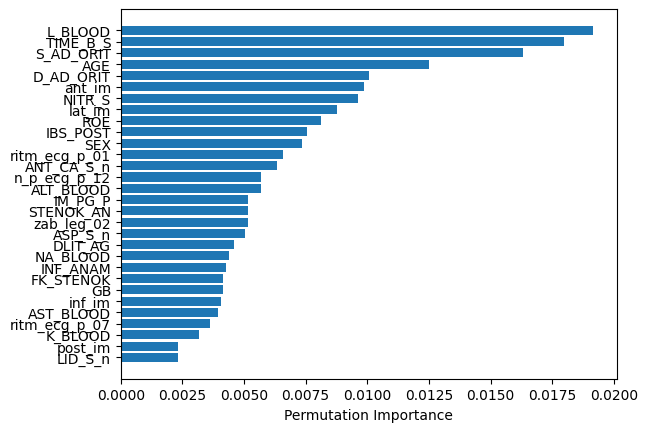

In [ ]:
# Permutation Based Feature Importance
perm_importance = permutation_importance(best_rf, X_train, y_train, random_state=42)
sorted_idx_perm = perm_importance.importances_mean.argsort()

# Select features whose mean importance is not null
index = np.abs(perm_importance.importances_mean[sorted_idx_perm]) > 0
index_sel_feats = sorted_idx_perm[index]
print("Selected features: ", X_train.columns[index_sel_feats], "(n. selected features: ",
      len(X_train.columns[index_sel_feats]), ")")

# Plot of some of the selected feats
index = np.abs(perm_importance.importances_mean[sorted_idx_perm]) > 0.002
index_plot = sorted_idx_perm[index]
plt.barh(X_train.columns[index_plot], perm_importance.importances_mean[index_plot])
plt.xlabel("Permutation Importance")

# RF classification on the selected features (importance grater than the mean importance)

### Data preparation and model training

In [ ]:
# Train and test set
X_train = train_set[['ZSN_A', 'DLIT_AG', 'np_05', 'np_07', 'nr_03', 'np_01', 'np_09',
                     'np_08', 'np_04', 'nr_11', 'nr_04', 'zab_leg_01', 'SIM_GIPERT',
                     'zab_leg_02', 'STENOK_AN', 'nr_08', 'endocr_01', 'FK_STENOK', 'GB',
                     'INF_ANAM', 'nr_07', 'IBS_POST', 'SEX', 'endocr_03', 'nr_01', 'nr_02',
                     'endocr_02', 'AGE', 'np_10']]
X_test = test_set[['ZSN_A', 'DLIT_AG', 'np_05', 'np_07', 'nr_03', 'np_01', 'np_09',
                   'np_08', 'np_04', 'nr_11', 'nr_04', 'zab_leg_01', 'SIM_GIPERT',
                   'zab_leg_02', 'STENOK_AN', 'nr_08', 'endocr_01', 'FK_STENOK', 'GB',
                   'INF_ANAM', 'nr_07', 'IBS_POST', 'SEX', 'endocr_03', 'nr_01', 'nr_02',
                   'endocr_02', 'AGE', 'np_10']]

In [ ]:
# Fitting the model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

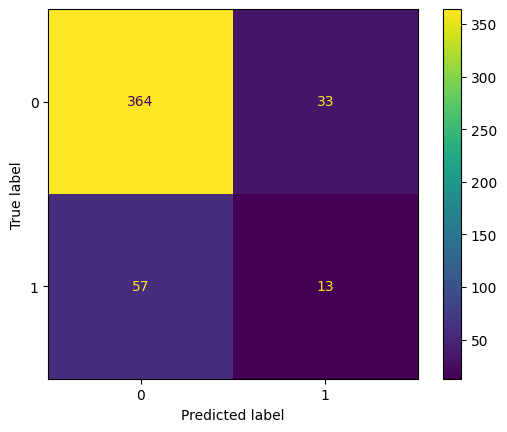

In [ ]:
# Confusion matrix
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [ ]:
# Model accuracy, sensitivity, specificity, precision and perfonce measure
tot = sum(sum(cm))
accuracy = (cm[0,0] + cm[1,1]) / tot
print("Accuracy:", accuracy)

sensitivity = cm[1,1] / (cm[1,1] + cm[1,0])
print("Model sensitivity: ", sensitivity)

specificity = cm[0,0] / (cm[0,0] + cm[0,1])
print("Model specificity: ", specificity)

precision = cm[1,1] / (cm[1,1] + cm[0,1])
print("Model precision: ", precision)

GabriMeasure = 0.2*accuracy + 0.4*sensitivity + 0.2*precision + 0.2*specificity
print("Model performance with our personal measure: ", GabriMeasure)

Accuracy: 0.8072805139186295
Model sensitivity:  0.18571428571428572
Model specificity:  0.9168765743073047
Model precision:  0.2826086956521739
Model performance with our personal measure:  0.47563887106133595


### Hyperparameters tuning

For the model hyperparameters:

In [ ]:
# Setting the hyperparameters
random_grid = {'n_estimators':[100,200,300,400,500],
               'criterion':['gini', 'entropy'],
               'max_depth':[5,10,20,30,40,50,60,70],
               'min_samples_split':[5,10,20,25,30,40,50],
               'max_features':[ 'sqrt', 'log2'],
               'max_leaf_nodes':[5,10,20,25,30,40,50],
               'min_samples_leaf':[1,100,200,300,400,500]
               }


# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state = 42)

# Random search of parameters, using 10 fold cross validation
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                               n_iter = 30, cv = 10, verbose=2, random_state=42,
                               n_jobs = -1, scoring='neg_mean_squared_error')

# Fit the random search model
rf_random.fit(X_train, y_train);

# Create a variable for the best model
best_rf = rf_random.best_estimator_

Fitting 10 folds for each of 30 candidates, totalling 300 fits


In [ ]:
# Print the best hyperparameters
print('Best hyperparameters:',  rf_random.best_params_)

Best hyperparameters: {'n_estimators': 500, 'min_samples_split': 25, 'min_samples_leaf': 1, 'max_leaf_nodes': 40, 'max_features': 'log2', 'max_depth': 40, 'criterion': 'entropy'}


For the threshold:

In [ ]:
# K-fold CV
K = 5
# Thresholds to determine if a predicted value falls in class 0 or 1
threshold = np.arange(0.1, 0.9, 0.05)
# Extremes of the dataset for the CV
ext = np.linspace(0, X_train.shape[0], K+1).astype(int)

# Metrics
acc = np.zeros(shape=K)
sens = np.zeros(shape=K)
spec = np.zeros(shape=K)
prec = np.zeros(shape=K)
accuracy = np.zeros(shape=len(threshold))
sensitivity = np.zeros(shape=len(threshold))
specificity = np.zeros(shape=len(threshold))
precision = np.zeros(shape=len(threshold))
gabri_measure = np.zeros(shape=len(threshold))

In [ ]:
# K-fold CV
for i in range(0, len(threshold)):
  for k in range(0, K):
    # Training and validation tests
    train = X_train.drop(X_train.iloc[ext[k]:ext[k+1]].index)
    y_t = y_train.drop(X_train.iloc[ext[k]:ext[k+1]].index)
    validation = X_train.iloc[ext[k]:ext[k+1]]
    y_val = y_train[ext[k]:ext[k+1]]

    # Building and training the RF
    rf = RandomForestClassifier(n_estimators=500, min_samples_split=25,
                                min_samples_leaf=1, max_leaf_nodes=40,
                                max_features='log2', max_depth=40,
                                criterion='entropy', random_state=42)
    rf.fit(train, y_t)

    # Predicting values
    predicted_values = rf.predict_proba(validation)[:, 1]
    predicted_class = np.zeros(predicted_values.shape)
    predicted_class[predicted_values > threshold[i]] = 1

    # Accuracy, sensitivity and specificity for every validation set
    cm = confusion_matrix(y_val, predicted_class)
    total = sum(sum(cm))
    acc[k] = (cm[0,0] + cm[1,1]) / total
    sens[k] = cm[1,1] / (cm[1,1] + cm[1,0])
    spec[k] = cm[0,0] / (cm[0,0] + cm[0,1])
    prec[k] = cm[1,1] / (cm[1,1] + cm[0,1])

  # Accuracy, sensitivity and specificity for the chosen threshold
  accuracy[i] = acc.mean()
  sensitivity[i] = sens.mean()
  specificity[i] = spec.mean()
  precision[i] = prec.mean()
  gabri_measure[i] = 0.2*accuracy[i] + 0.4*sensitivity[i] + 0.2*precision[i] + 0.2*specificity[i]

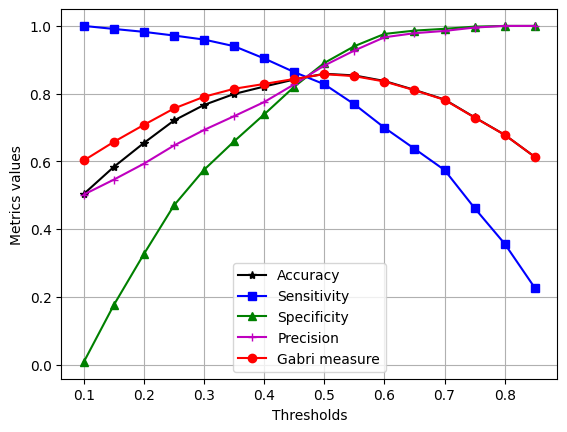

In [ ]:
# Plots
plt.plot(threshold, accuracy, 'k*-', label='Accuracy')
plt.plot(threshold, sensitivity, 'bs-', label='Sensitivity')
plt.plot(threshold, specificity, 'g^-', label='Specificity')
plt.plot(threshold, precision, 'm+-', label='Precision')
plt.plot(threshold, gabri_measure, 'ro-', label='Gabri measure')
plt.xlabel('Thresholds')
plt.ylabel('Metrics values')
plt.grid(True)
plt.legend()
plt.show()

### Model testing

Best model according to RandomizedSearchCV:

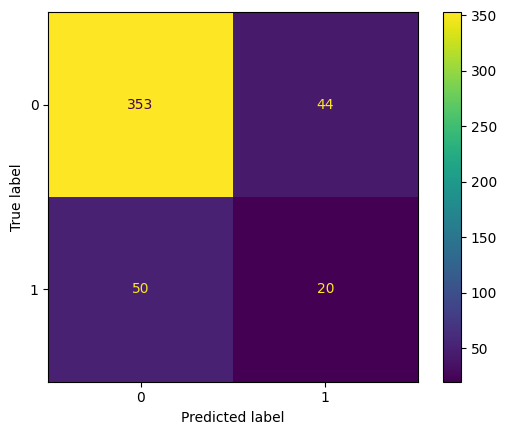

In [ ]:
# Confusion matrix
y_pred = best_rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [ ]:
# Model accuracy, sensitivity, specificity, precision and perfonce measure
tot = sum(sum(cm))
accuracy = (cm[0,0] + cm[1,1]) / tot
print("Accuracy:", accuracy)

sensitivity = cm[1,1] / (cm[1,1] + cm[1,0])
print("Model sensitivity: ", sensitivity)

specificity = cm[0,0] / (cm[0,0] + cm[0,1])
print("Model specificity: ", specificity)

precision = cm[1,1] / (cm[1,1] + cm[0,1])
print("Model precision: ", precision)

GabriMeasure = 0.5*sensitivity + 0.3*precision + 0.2*specificity
print("Model performance with our personal measure: ", GabriMeasure)

Accuracy: 0.7987152034261242
Model sensitivity:  0.2857142857142857
Model specificity:  0.889168765743073
Model precision:  0.3125
Model performance with our personal measure:  0.5143625081195538


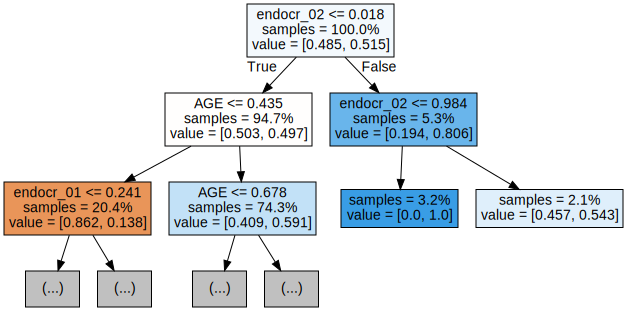

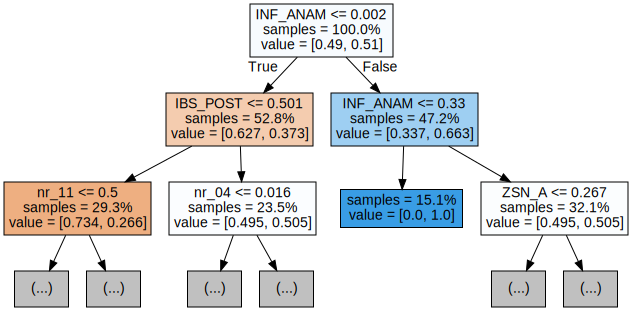

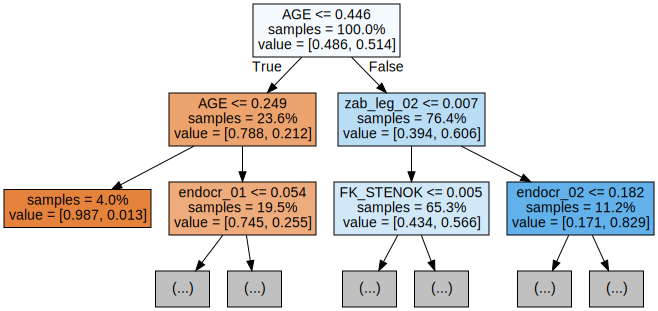

In [ ]:
# Export the first three decision trees from the forest
for i in range(3):
    tree = best_rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_test.columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

Best model, with a different threshold:

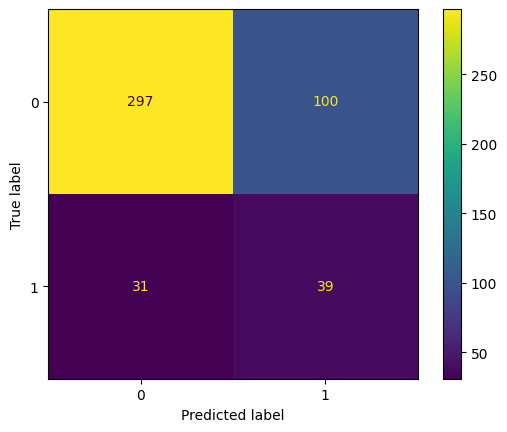

In [ ]:
# Confusion matrix
y_pred = (best_rf.predict_proba(X_test)[:,1] > 0.4).astype(int)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [ ]:
# Model accuracy, sensitivity, specificity, precision and perfonce measure
tot = sum(sum(cm))
accuracy = (cm[0,0] + cm[1,1]) / tot
print("Accuracy:", accuracy)

sensitivity = cm[1,1] / (cm[1,1] + cm[1,0])
print("Model sensitivity: ", sensitivity)

specificity = cm[0,0] / (cm[0,0] + cm[0,1])
print("Model specificity: ", specificity)

precision = cm[1,1] / (cm[1,1] + cm[0,1])
print("Model precision: ", precision)

GabriMeasure = 0.2*accuracy + 0.4*sensitivity + 0.2*precision + 0.2*specificity
print("Model performance with our personal measure: ", GabriMeasure)

Accuracy: 0.7194860813704497
Model sensitivity:  0.5571428571428572
Model specificity:  0.7481108312342569
Model precision:  0.2805755395683453
Model performance with our personal measure:  0.5724916332917532


# RF classification on the selected features (permutation based)

### Data preparation and model training

In [ ]:
# Train and test set
X_train = train_set[['n_r_ecg_p_06', 'ritm_ecg_p_02', 'FIB_G_POST', 'K_SH_POST',
                     'n_p_ecg_p_06', 'ritm_ecg_p_08', 'n_p_ecg_p_10', 'n_r_ecg_p_05',
                     'TRENT_S_n', 'nr_04', 'n_p_ecg_p_03', 'B_BLOK_S_n', 'n_p_ecg_p_11',
                     'n_r_ecg_p_08', 'SVT_POST', 'SIM_GIPERT', 'O_L_POST', 'ZSN_A',
                     'endocr_02', 'nr_02', 'n_p_ecg_p_07', 'n_r_ecg_p_03', 'nr_11',
                     'n_p_ecg_p_08', 'zab_leg_03', 'zab_leg_01', 'endocr_01', 'MP_TP_POST',
                     'n_r_ecg_p_01', 'GEPAR_S_n', 'LID_S_n', 'post_im', 'K_BLOOD',
                     'ritm_ecg_p_07', 'AST_BLOOD', 'inf_im', 'GB', 'FK_STENOK', 'INF_ANAM',
                     'NA_BLOOD', 'DLIT_AG', 'ASP_S_n', 'zab_leg_02', 'STENOK_AN', 'IM_PG_P',
                     'ALT_BLOOD', 'n_p_ecg_p_12', 'ANT_CA_S_n', 'ritm_ecg_p_01', 'SEX',
                     'IBS_POST', 'ROE', 'lat_im', 'NITR_S', 'ant_im', 'D_AD_ORIT', 'AGE',
                     'S_AD_ORIT', 'TIME_B_S', 'L_BLOOD']]
X_test = test_set[['n_r_ecg_p_06', 'ritm_ecg_p_02', 'FIB_G_POST', 'K_SH_POST',
                   'n_p_ecg_p_06', 'ritm_ecg_p_08', 'n_p_ecg_p_10', 'n_r_ecg_p_05',
                   'TRENT_S_n', 'nr_04', 'n_p_ecg_p_03', 'B_BLOK_S_n', 'n_p_ecg_p_11',
                   'n_r_ecg_p_08', 'SVT_POST', 'SIM_GIPERT', 'O_L_POST', 'ZSN_A',
                   'endocr_02', 'nr_02', 'n_p_ecg_p_07', 'n_r_ecg_p_03', 'nr_11',
                   'n_p_ecg_p_08', 'zab_leg_03', 'zab_leg_01', 'endocr_01', 'MP_TP_POST',
                   'n_r_ecg_p_01', 'GEPAR_S_n', 'LID_S_n', 'post_im', 'K_BLOOD',
                   'ritm_ecg_p_07', 'AST_BLOOD', 'inf_im', 'GB', 'FK_STENOK', 'INF_ANAM',
                   'NA_BLOOD', 'DLIT_AG', 'ASP_S_n', 'zab_leg_02', 'STENOK_AN', 'IM_PG_P',
                   'ALT_BLOOD', 'n_p_ecg_p_12', 'ANT_CA_S_n', 'ritm_ecg_p_01', 'SEX',
                   'IBS_POST', 'ROE', 'lat_im', 'NITR_S', 'ant_im', 'D_AD_ORIT', 'AGE',
                   'S_AD_ORIT', 'TIME_B_S', 'L_BLOOD']]

In [ ]:
# Fitting the model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

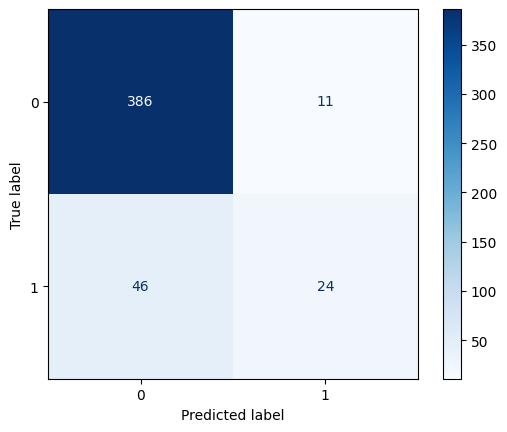

In [ ]:
# Confusion matrix
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues');

In [ ]:
# Model accuracy, sensitivity, specificity, precision and perfonce measure
tot = sum(sum(cm))
accuracy = (cm[0,0] + cm[1,1]) / tot
print("Accuracy:", accuracy)

sensitivity = cm[1,1] / (cm[1,1] + cm[1,0])
print("Model sensitivity: ", sensitivity)

specificity = cm[0,0] / (cm[0,0] + cm[0,1])
print("Model specificity: ", specificity)

precision = cm[1,1] / (cm[1,1] + cm[0,1])
print("Model precision: ", precision)

GabriMeasure = 0*accuracy + 0.5*sensitivity + 0.3*precision + 0.2*specificity
print("Model performance with our personal measure: ", GabriMeasure)

Accuracy: 0.8779443254817987
Model sensitivity:  0.34285714285714286
Model specificity:  0.9722921914357683
Model precision:  0.6857142857142857
Model performance with our personal measure:  0.5716012954300108


### Hyperparameters tuning

In [ ]:
# Setting the hyperparameters
random_grid = {'n_estimators':[100,200,300,400,500],
               'criterion':['gini', 'entropy'],
               'max_depth':[5,10,20,30,40,50,60,70],
               'min_samples_split':[5,10,20,25,30,40,50],
               'max_features':[ 'sqrt', 'log2'],
               'max_leaf_nodes':[5,10,20,25,30,40,50],
               'min_samples_leaf':[1,100,200,300,400,500]
               }


# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state = 42)

# Random search of parameters, using 10 fold cross validation
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                               n_iter = 30, cv = 10, verbose=2, random_state=42,
                               n_jobs = -1, scoring='neg_mean_squared_error')

# Fit the random search model
rf_random.fit(X_train, y_train);

# Create a variable for the best model
best_rf = rf_random.best_estimator_

Fitting 10 folds for each of 30 candidates, totalling 300 fits


In [ ]:
# Print the best hyperparameters
print('Best hyperparameters:',  rf_random.best_params_)

Best hyperparameters: {'n_estimators': 500, 'min_samples_split': 25, 'min_samples_leaf': 1, 'max_leaf_nodes': 40, 'max_features': 'log2', 'max_depth': 40, 'criterion': 'entropy'}


In [ ]:
# K-fold CV
K = 5
# Thresholds to determine if a predicted value falls in class 0 or 1
threshold = np.arange(0.1, 0.9, 0.05)
# Extremes of the dataset for the CV
ext = np.linspace(0, X_train.shape[0], K+1).astype(int)

# Metrics
acc = np.zeros(shape=K)
sens = np.zeros(shape=K)
spec = np.zeros(shape=K)
prec = np.zeros(shape=K)
accuracy = np.zeros(shape=len(threshold))
sensitivity = np.zeros(shape=len(threshold))
specificity = np.zeros(shape=len(threshold))
precision = np.zeros(shape=len(threshold))
gabri_measure = np.zeros(shape=len(threshold))

In [ ]:
# K-fold CV
for i in range(0, len(threshold)):
  for k in range(0, K):
    # Training and validation tests
    train = X_train.drop(X_train.iloc[ext[k]:ext[k+1]].index)
    y_t = y_train.drop(X_train.iloc[ext[k]:ext[k+1]].index)
    validation = X_train.iloc[ext[k]:ext[k+1]]
    y_val = y_train[ext[k]:ext[k+1]]

    # Building and training the RF
    rf = RandomForestClassifier(n_estimators=500, min_samples_split=25,
                                min_samples_leaf=1, max_leaf_nodes=40,
                                max_features='log2', max_depth=40,
                                criterion='entropy', random_state=42)
    rf.fit(train, y_t)

    # Predicting values
    predicted_values = rf.predict_proba(validation)[:, 1]
    predicted_class = np.zeros(predicted_values.shape)
    predicted_class[predicted_values > threshold[i]] = 1

    # Accuracy, sensitivity and specificity for every validation set
    cm = confusion_matrix(y_val, predicted_class)
    total = sum(sum(cm))
    acc[k] = (cm[0,0] + cm[1,1]) / total
    sens[k] = cm[1,1] / (cm[1,1] + cm[1,0])
    spec[k] = cm[0,0] / (cm[0,0] + cm[0,1])
    prec[k] = cm[1,1] / (cm[1,1] + cm[0,1])

  # Accuracy, sensitivity and specificity for the chosen threshold
  accuracy[i] = acc.mean()
  sensitivity[i] = sens.mean()
  specificity[i] = spec.mean()
  precision[i] = prec.mean()
  gabri_measure[i] = 0*accuracy[i] + 0.5*sensitivity[i] + 0.3*precision[i] + 0.2*specificity[i]

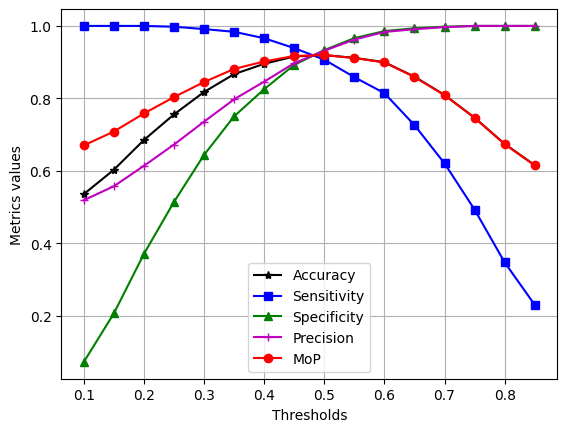

In [ ]:
# Plots
plt.plot(threshold, accuracy, 'k*-', label='Accuracy')
plt.plot(threshold, sensitivity, 'bs-', label='Sensitivity')
plt.plot(threshold, specificity, 'g^-', label='Specificity')
plt.plot(threshold, precision, 'm+-', label='Precision')
plt.plot(threshold, gabri_measure, 'ro-', label='MoP')
plt.xlabel('Thresholds')
plt.ylabel('Metrics values')
plt.grid(True)
plt.legend()
plt.show()

### Model testing

Best model according to RandomizedSearchCV:

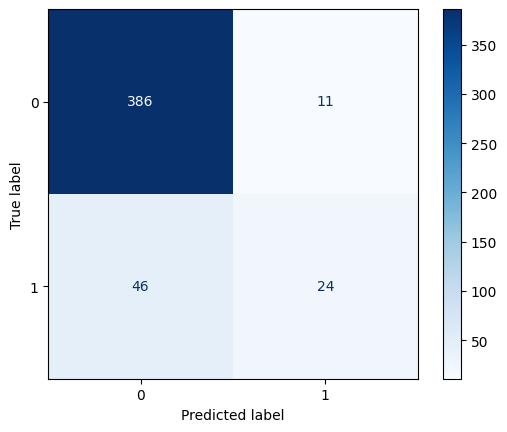

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues');

In [ ]:
# Model accuracy, sensitivity, specificity, precision and perfonce measure
tot = sum(sum(cm))
accuracy = (cm[0,0] + cm[1,1]) / tot
print("Accuracy:", accuracy)

sensitivity = cm[1,1] / (cm[1,1] + cm[1,0])
print("Model sensitivity: ", sensitivity)

specificity = cm[0,0] / (cm[0,0] + cm[0,1])
print("Model specificity: ", specificity)

precision = cm[1,1] / (cm[1,1] + cm[0,1])
print("Model precision: ", precision)

GabriMeasure = 0.5*sensitivity + 0.3*precision + 0.2*specificity
print("Model performance with our personal measure: ", GabriMeasure)

Accuracy: 0.8779443254817987
Model sensitivity:  0.34285714285714286
Model specificity:  0.9722921914357683
Model precision:  0.6857142857142857
Model performance with our personal measure:  0.5716012954300108


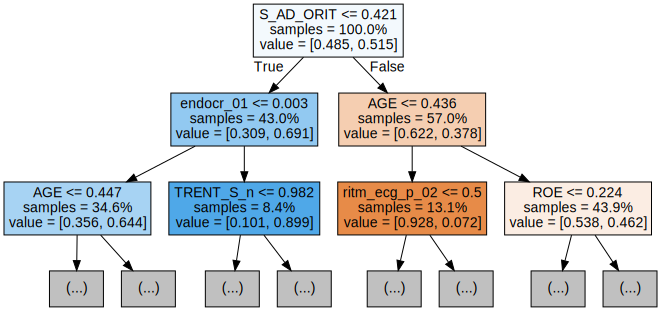

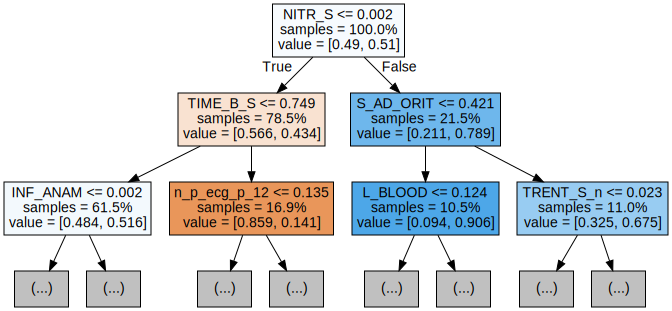

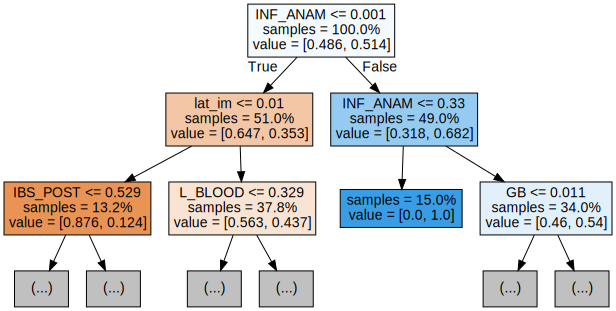

In [ ]:
# Export the first three decision trees from the forest
for i in range(3):
    tree = best_rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_test.columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

Best model with a different threshold

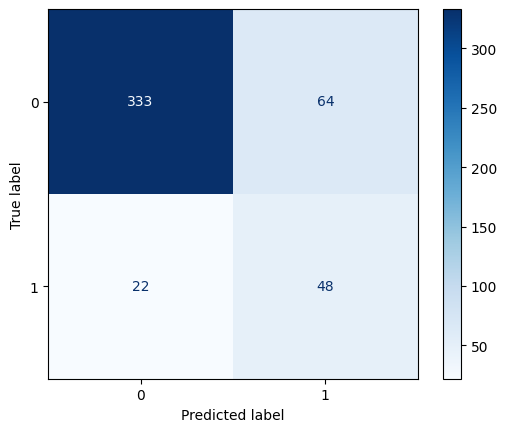

In [ ]:
# Confusion matrix
y_pred = (best_rf.predict_proba(X_test)[:,1] > 0.4).astype(int)
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap='Blues');

In [ ]:
# Model accuracy, sensitivity, specificity, precision and perfonce measure
tot = sum(sum(cm))
accuracy = (cm[0,0] + cm[1,1]) / tot
print("Accuracy:", accuracy)

sensitivity = cm[1,1] / (cm[1,1] + cm[1,0])
print("Model sensitivity: ", sensitivity)

specificity = cm[0,0] / (cm[0,0] + cm[0,1])
print("Model specificity: ", specificity)

precision = cm[1,1] / (cm[1,1] + cm[0,1])
print("Model precision: ", precision)

GabriMeasure = 0.5*sensitivity + 0.3*precision + 0.2*specificity
print("Model performance with our personal measure: ", GabriMeasure)

Accuracy: 0.815845824411135
Model sensitivity:  0.6857142857142857
Model specificity:  0.8387909319899244
Model precision:  0.42857142857142855
Model performance with our personal measure:  0.6391867578265563


# Data saving

In [ ]:
# Train and test with selected features only (vua permutation method)
X_train = train_set[['n_r_ecg_p_06', 'ritm_ecg_p_02', 'FIB_G_POST', 'K_SH_POST',
                     'n_p_ecg_p_06', 'ritm_ecg_p_08', 'n_p_ecg_p_10', 'n_r_ecg_p_05',
                     'TRENT_S_n', 'nr_04', 'n_p_ecg_p_03', 'B_BLOK_S_n', 'n_p_ecg_p_11',
                     'n_r_ecg_p_08', 'SVT_POST', 'SIM_GIPERT', 'O_L_POST', 'ZSN_A',
                     'endocr_02', 'nr_02', 'n_p_ecg_p_07', 'n_r_ecg_p_03', 'nr_11',
                     'n_p_ecg_p_08', 'zab_leg_03', 'zab_leg_01', 'endocr_01', 'MP_TP_POST',
                     'n_r_ecg_p_01', 'GEPAR_S_n', 'LID_S_n', 'post_im', 'K_BLOOD',
                     'ritm_ecg_p_07', 'AST_BLOOD', 'inf_im', 'GB', 'FK_STENOK', 'INF_ANAM',
                     'NA_BLOOD', 'DLIT_AG', 'ASP_S_n', 'zab_leg_02', 'STENOK_AN', 'IM_PG_P',
                     'ALT_BLOOD', 'n_p_ecg_p_12', 'ANT_CA_S_n', 'ritm_ecg_p_01', 'SEX',
                     'IBS_POST', 'ROE', 'lat_im', 'NITR_S', 'ant_im', 'D_AD_ORIT', 'AGE',
                     'S_AD_ORIT', 'TIME_B_S', 'L_BLOOD']]
X_test = test_set[['n_r_ecg_p_06', 'ritm_ecg_p_02', 'FIB_G_POST', 'K_SH_POST',
                   'n_p_ecg_p_06', 'ritm_ecg_p_08', 'n_p_ecg_p_10', 'n_r_ecg_p_05',
                   'TRENT_S_n', 'nr_04', 'n_p_ecg_p_03', 'B_BLOK_S_n', 'n_p_ecg_p_11',
                   'n_r_ecg_p_08', 'SVT_POST', 'SIM_GIPERT', 'O_L_POST', 'ZSN_A',
                   'endocr_02', 'nr_02', 'n_p_ecg_p_07', 'n_r_ecg_p_03', 'nr_11',
                   'n_p_ecg_p_08', 'zab_leg_03', 'zab_leg_01', 'endocr_01', 'MP_TP_POST',
                   'n_r_ecg_p_01', 'GEPAR_S_n', 'LID_S_n', 'post_im', 'K_BLOOD',
                   'ritm_ecg_p_07', 'AST_BLOOD', 'inf_im', 'GB', 'FK_STENOK', 'INF_ANAM',
                   'NA_BLOOD', 'DLIT_AG', 'ASP_S_n', 'zab_leg_02', 'STENOK_AN', 'IM_PG_P',
                   'ALT_BLOOD', 'n_p_ecg_p_12', 'ANT_CA_S_n', 'ritm_ecg_p_01', 'SEX',
                   'IBS_POST', 'ROE', 'lat_im', 'NITR_S', 'ant_im', 'D_AD_ORIT', 'AGE',
                   'S_AD_ORIT', 'TIME_B_S', 'L_BLOOD']]

In [ ]:
# Saving the train and test set with selected features (permutation based selection)
train_set_fs = pd.concat([X_train, y_train], axis=1)
train_set_fs.to_csv('train_set_fs_mice.csv')

test_set_fs = pd.concat([X_test, y_test], axis=1)
test_set_fs.to_csv('test_set_fs_mice.csv')